/Users/ter/Apps/anaconda3/envs/tfm/lib/python3.10/site-packages/pennylane/operation.py:2631: PennyLaneDeprecationWarning: AnyWires is deprecated and will be removed in v0.43.  If your operation accepts any number of wires, set num_wires=None instead.
  warnings.warn(
/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_7901/3804103961.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


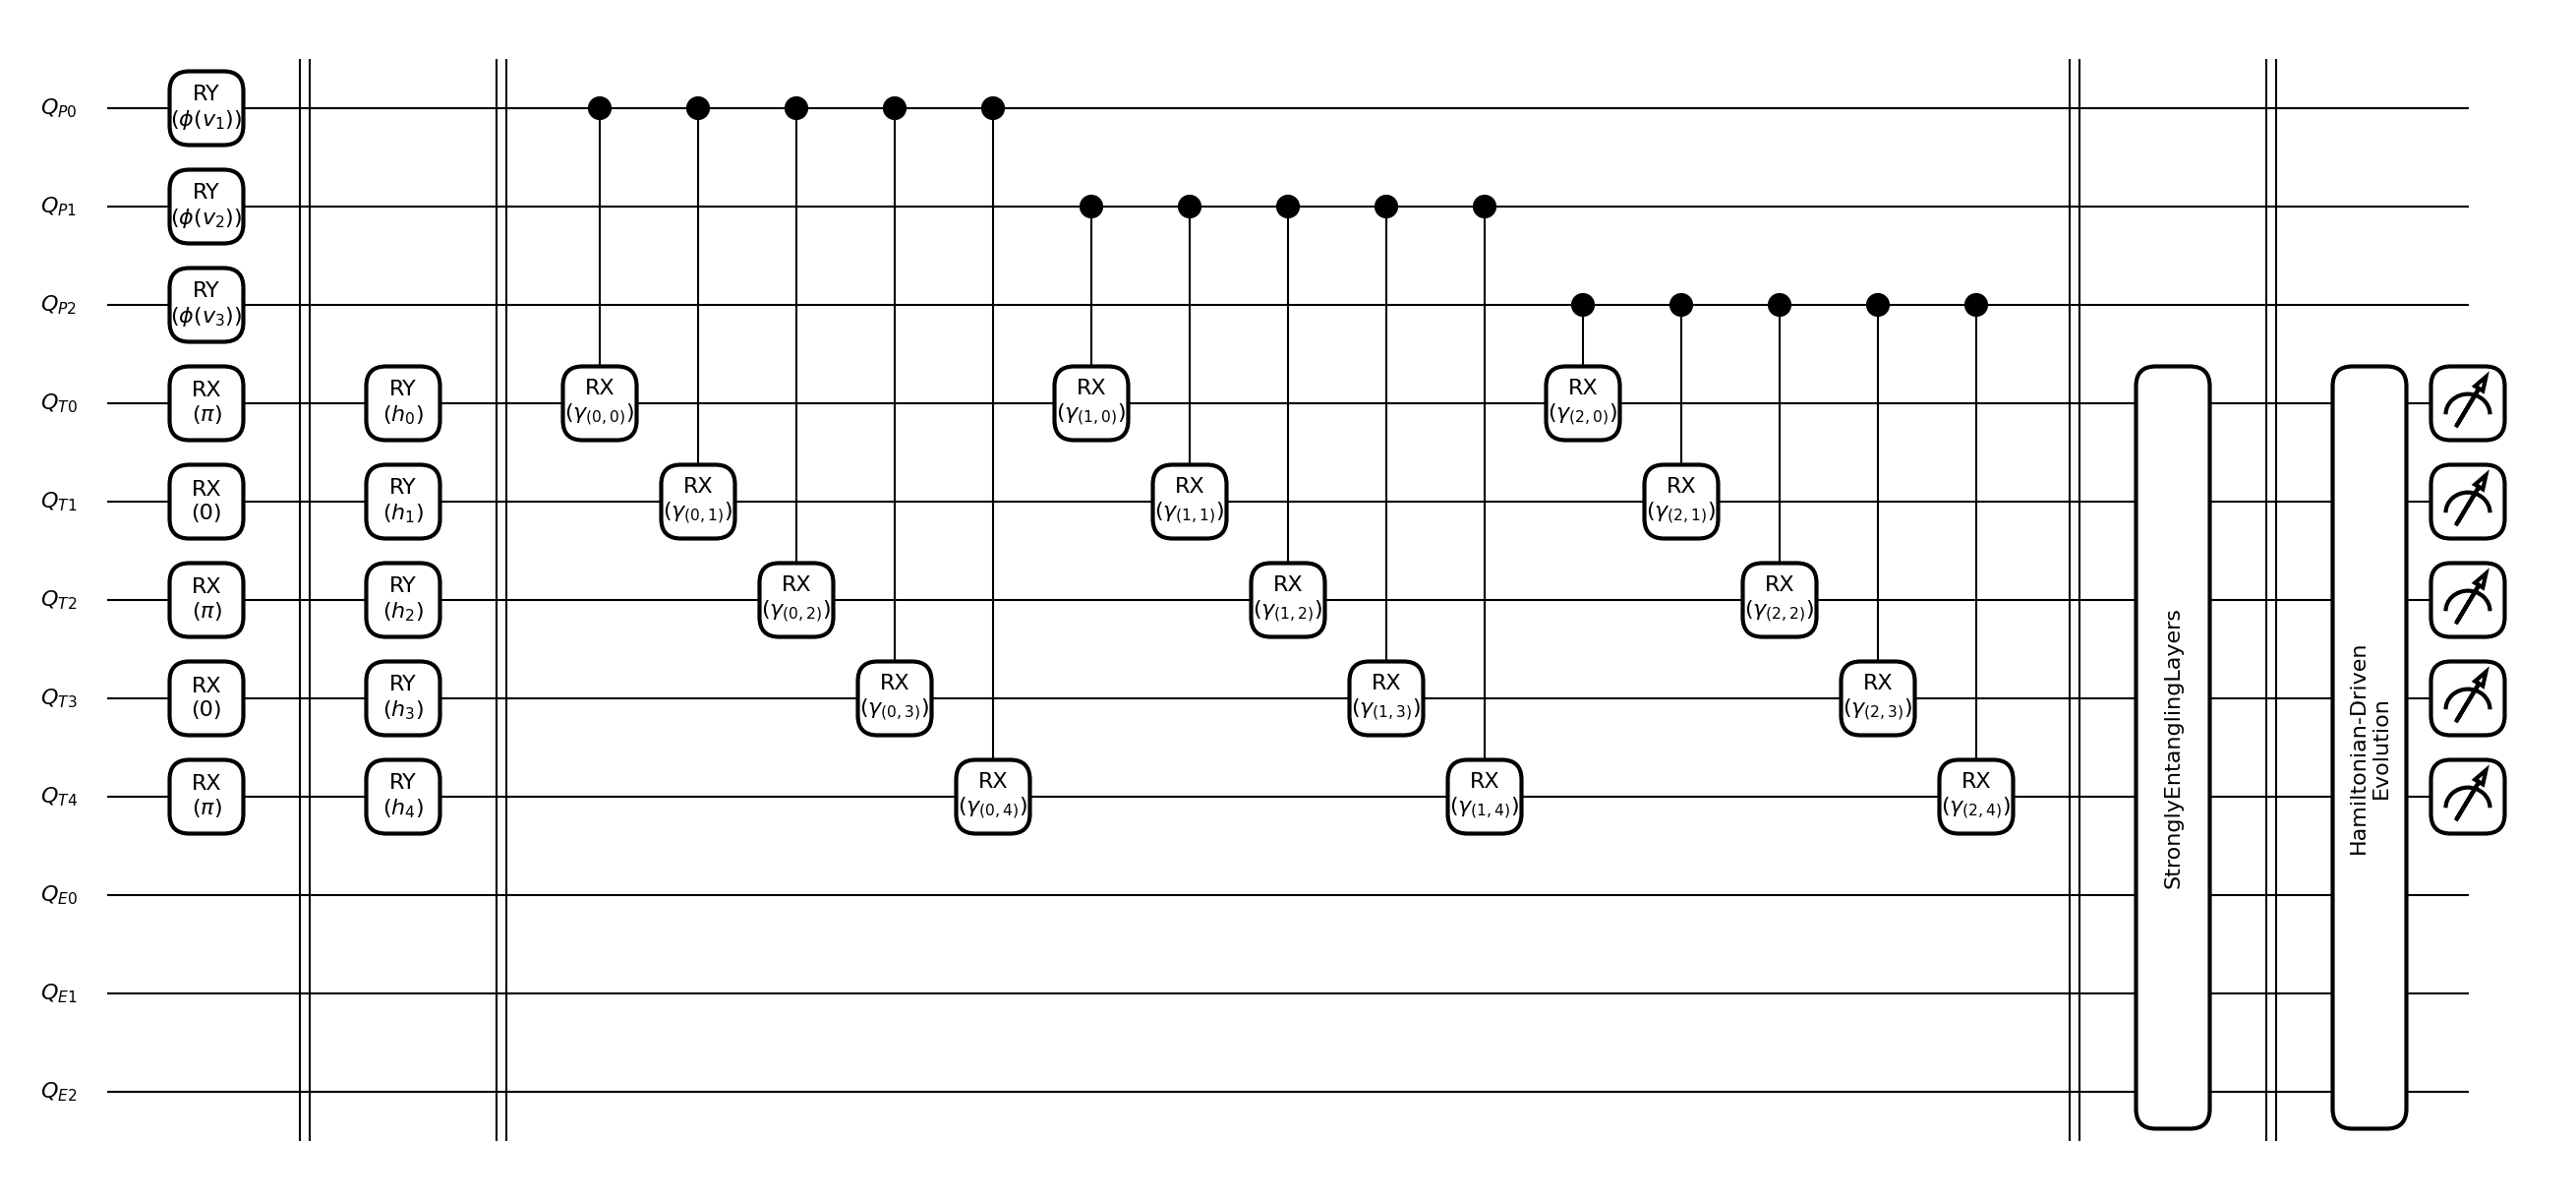

In [101]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import itertools

# --- 1. CONFIGURATION & WIRES ---
BITS_PER_TOKEN = 5 
n_prop_qubits = 3
n_ancillas = 3
n_token_ancilla = BITS_PER_TOKEN + n_ancillas
H_LOCAL = 3

prop_wires = [f"$Q_{{P{i}}}$" for i in range(n_prop_qubits)]
token_wires = [f"$Q_{{T{i}}}$" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"$Q_{{E{i}}}$" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
token_ancilla_ws = token_wires + ancilla_wires 

# Use default device for drawing
dev = qml.device("default.qubit", wires=all_wires)

class HamiltonianEvolution(qml.operation.Operation):
    num_wires = qml.operation.AnyWires
    grad_method = None
    
    def label(self, decimals=None, base_label=None, cache=None):
        # The text to display inside the box
        return "Hamiltonian-Driven\nEvolution"


def zstring_combos(wires):
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def molecular_property_encoder(props):
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)

def token_encoder(token_bits):
    for i in range(BITS_PER_TOKEN):
        if token_bits[i] == 1:
            angle = r"$\pi$"
        else:
            angle = "0"
        qml.RX(angle, wires=token_wires[i])

def operator_layer(theta_params, theta_prop, wires):
    # Property Entanglement
    for j, prop_w in enumerate(prop_wires):
        for i, target_w in enumerate(token_wires):
            qml.CRX(theta_prop[j][i][0], wires=[prop_w, target_w])

    qml.Barrier(wires=all_wires)
    
    # Backbone Entanglement (Strongly Entangling Layers)
    qml.StronglyEntanglingLayers(theta_params, wires=token_ancilla_ws)


# --- 4. THE DRAWING QNODE ---

@qml.qnode(dev)
def draw_one_layer_circuit(token_bits, props, theta_params, theta_prop, sigma_params, attention_context):
    # A. Data Re-injection
    token_encoder(token_bits)
    molecular_property_encoder(props) 
    
    qml.Barrier(wires=all_wires)
    
    # B. Attention Context Injection
    for i, val in enumerate(attention_context):
        qml.RY(val, wires=token_wires[i])
        
    qml.Barrier(wires=all_wires)
    
    # C. Entanglement Operator V(theta)
    operator_layer(theta_params, theta_prop, wires=all_wires)
    
    qml.Barrier(wires=all_wires)
    
    # D. Diagonal Hamiltonian Evolution (Black Box)
    # We substitute the loop of MultiRZ gates with this single operation
    HamiltonianEvolution(wires=token_ancilla_ws)
    
    return qml.probs(wires=token_wires)

dummy_token_bits = np.array([1, 0, 1, 0, 1]) 
dummy_props = np.array([r"$\phi(v_1)$", r"$\phi(v_2)$", r"$\phi(v_3)$"])
dummy_attn = np.array([f"$h_{{{i}}}$" for i in range(BITS_PER_TOKEN)])

# Theta Params
dummy_theta = [
    [
        [f'\\theta_{{{i},x}}', f'\\theta_{{{i},y}}', f'\\theta_{{{i},z}}']
        for i in range(len(token_ancilla_ws))
    ]
]

# Theta Prop
dummy_theta_prop = []
for j in range(n_prop_qubits):
    row = [] 
    for i in range(BITS_PER_TOKEN):
        row.append([f"$\\gamma_{{{j, i}}}$"]) 
    dummy_theta_prop.append(row)

# Sigma Params (passed but unused by the black box, kept for signature compatibility)
dummy_sigma = [f"$\\sigma_{{{i}}}$" for i in range(20)]

# --- DRAWING ---

fig, ax = qml.draw_mpl(draw_one_layer_circuit, scale=0.9, decimals=2)(
    dummy_token_bits, 
    dummy_props, 
    dummy_theta, 
    dummy_theta_prop, 
    dummy_sigma, 
    dummy_attn
)

# Apply font styling
for text in ax.texts:
    text.set_fontsize(16)

# bbox_inches='tight' removes the massive white margins typical in Matplotlib
fig.savefig("quantum_circuit_architecture.svg", format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_7901/2746875368.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


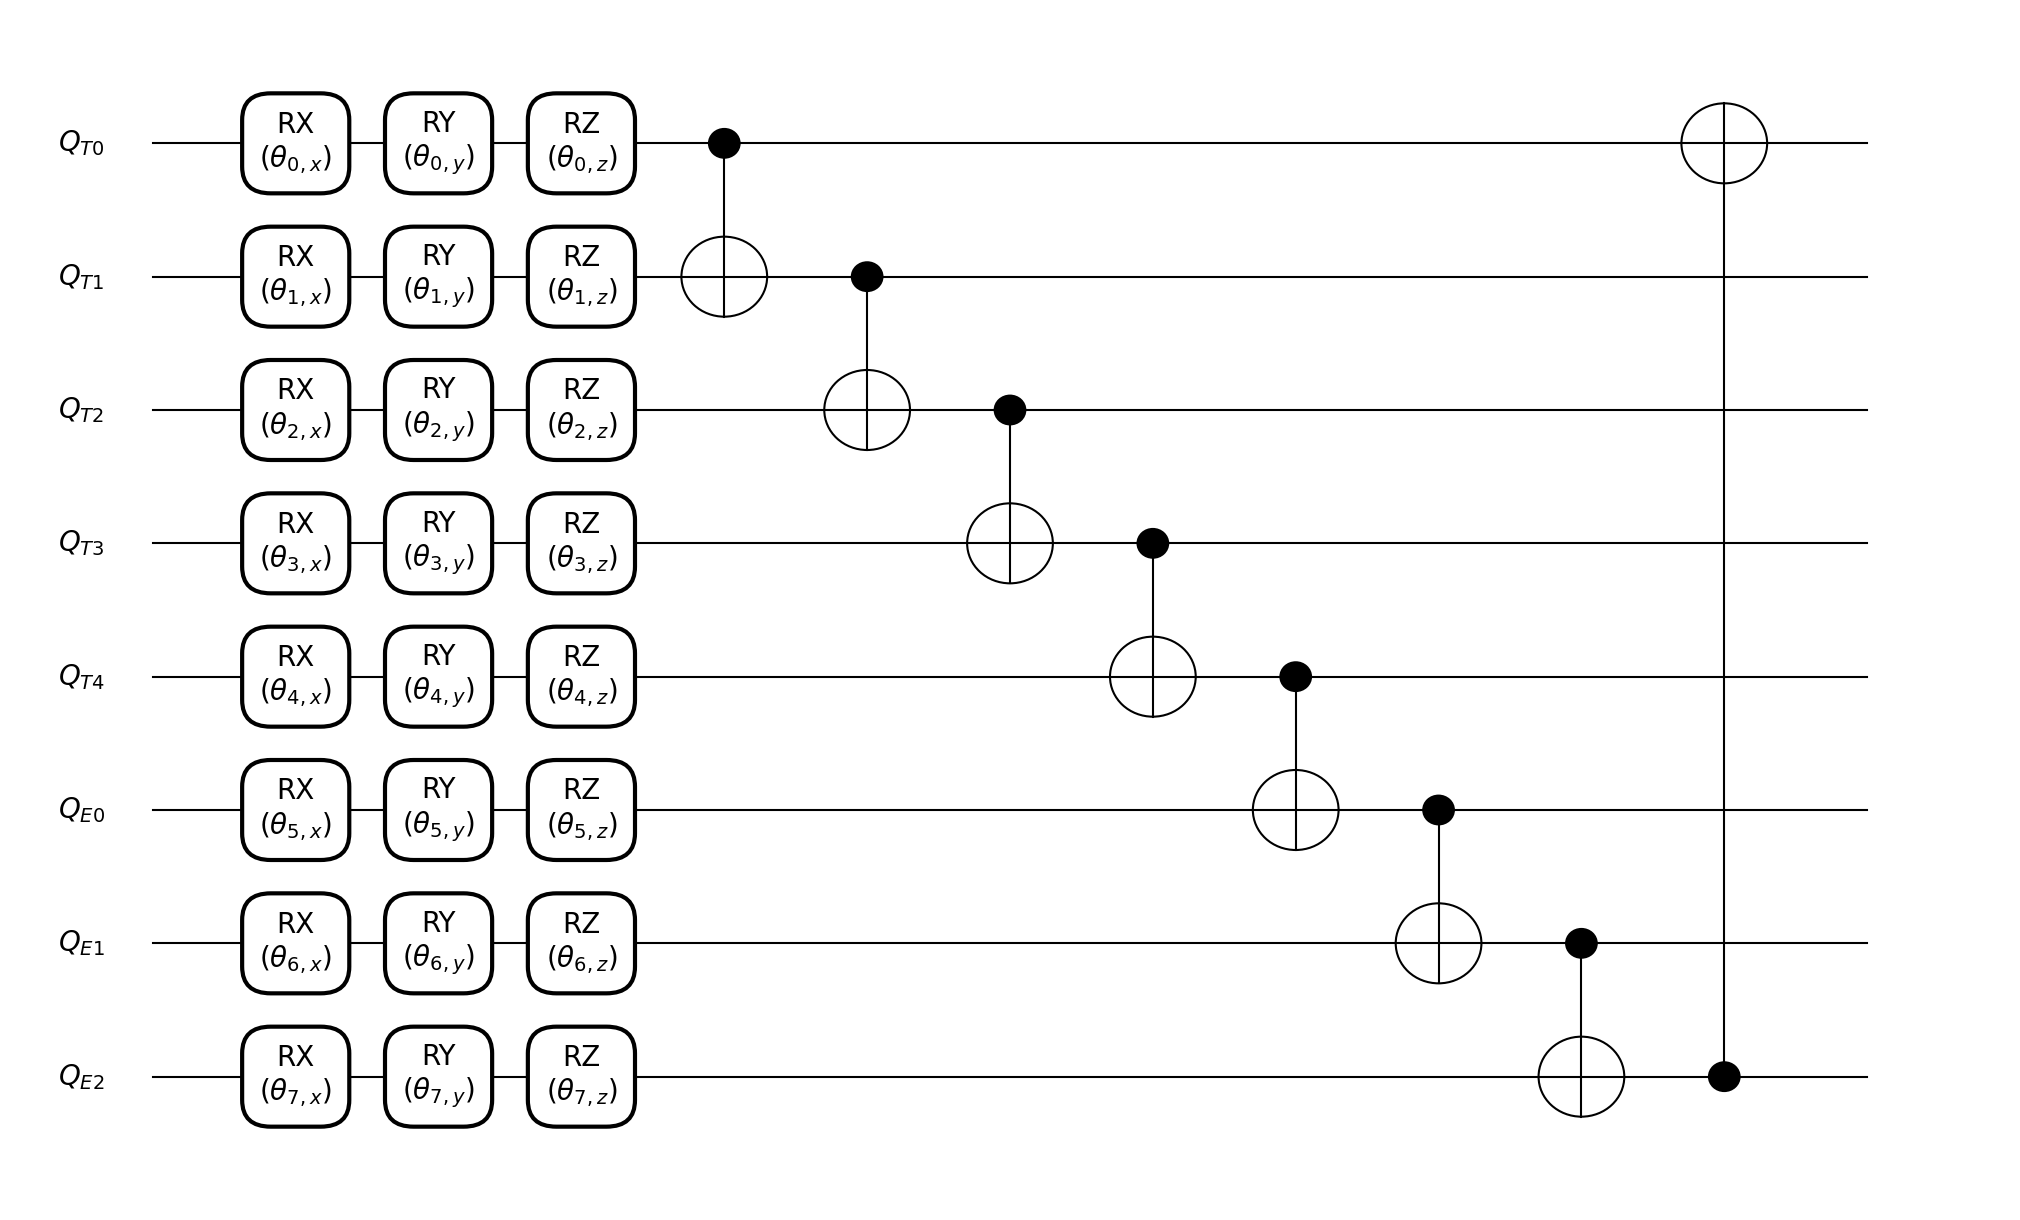

In [93]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import itertools

# --- 1. CONFIGURATION & WIRES ---
BITS_PER_TOKEN = 5 
n_prop_qubits = 3
n_ancillas = 3
n_token_ancilla = BITS_PER_TOKEN + n_ancillas
H_LOCAL = 3

prop_wires = [f"$Q_{{P{i}}}$" for i in range(n_prop_qubits)]
token_wires = [f"$Q_{{T{i}}}$" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"$Q_{{E{i}}}$" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
token_ancilla_ws = token_wires + ancilla_wires 

# Use default device for drawing
dev = qml.device("default.qubit", wires=all_wires)


def operator_layer(theta_params, theta_prop, wires):
    # FIX 1: Extract the parameters for the first layer (index 0)
    # theta_params has shape (n_layers, n_wires, 3) -> We want layer 0
    layer_params = theta_params[0]

    # FIX 2: Iterate over token_ancilla_ws (8 wires) instead of just token_wires
    # to match the shape of dummy_theta and the ansatz structure
    for i, wire in enumerate(token_ancilla_ws):
        qml.RX(layer_params[i][0], wires=wire)
        qml.RY(layer_params[i][1], wires=wire)
        qml.RZ(layer_params[i][2], wires=wire)
    
    # 2. CNOT Ring
    n = len(token_ancilla_ws)
    for i in range(n):
        qml.CNOT(wires=[token_ancilla_ws[i], token_ancilla_ws[(i+1) % n]])


# --- 4. THE DRAWING QNODE ---

@qml.qnode(dev)
def draw_one_layer_circuit(token_bits, props, theta_params, theta_prop, sigma_params, attention_context):
    
    # C. Entanglement Operator V(theta)
    operator_layer(theta_params, theta_prop, wires=all_wires)
    
# --- 5. DATA GENERATION ---

dummy_token_bits = np.array([1, 0, 1, 0, 1]) 
dummy_props = np.array([r"$\phi(v_1)$", r"$\phi(v_2)$", r"$\phi(v_3)$"])
dummy_attn = np.array([f"$h_{{{i}}}$" for i in range(BITS_PER_TOKEN)])

# Theta Params: Shape is (1, 8, 3)
dummy_theta = [
    [
        [f"$\\theta_{{{i},x}}$", f'$\\theta_{{{i},y}}$', f'$\\theta_{{{i},z}}$']
        for i in range(len(token_ancilla_ws))
    ]
]

# Theta Prop
dummy_theta_prop = []
for j in range(BITS_PER_TOKEN):
    row = [] 
    for i in range(n_prop_qubits):
        row.append([f"$\\gamma_{{{j, i}}}$"]) 
    dummy_theta_prop.append(row)

dummy_sigma = [f"$\\sigma_{{{i}}}$" for i in range(20)]

# --- DRAWING ---

# Increased figsize to make sure the CNOT ring and labels are readable
fig, ax = qml.draw_mpl(draw_one_layer_circuit, scale=0.8, decimals=2)(
    dummy_token_bits, 
    dummy_props, 
    dummy_theta, 
    dummy_theta_prop, 
    dummy_sigma, 
    dummy_attn
)

fig.set_size_inches(20, 12)

# Apply font styling
for text in ax.texts:
    text.set_fontsize(20)
plt.tight_layout()
plt.show()

/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_7901/1323179333.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


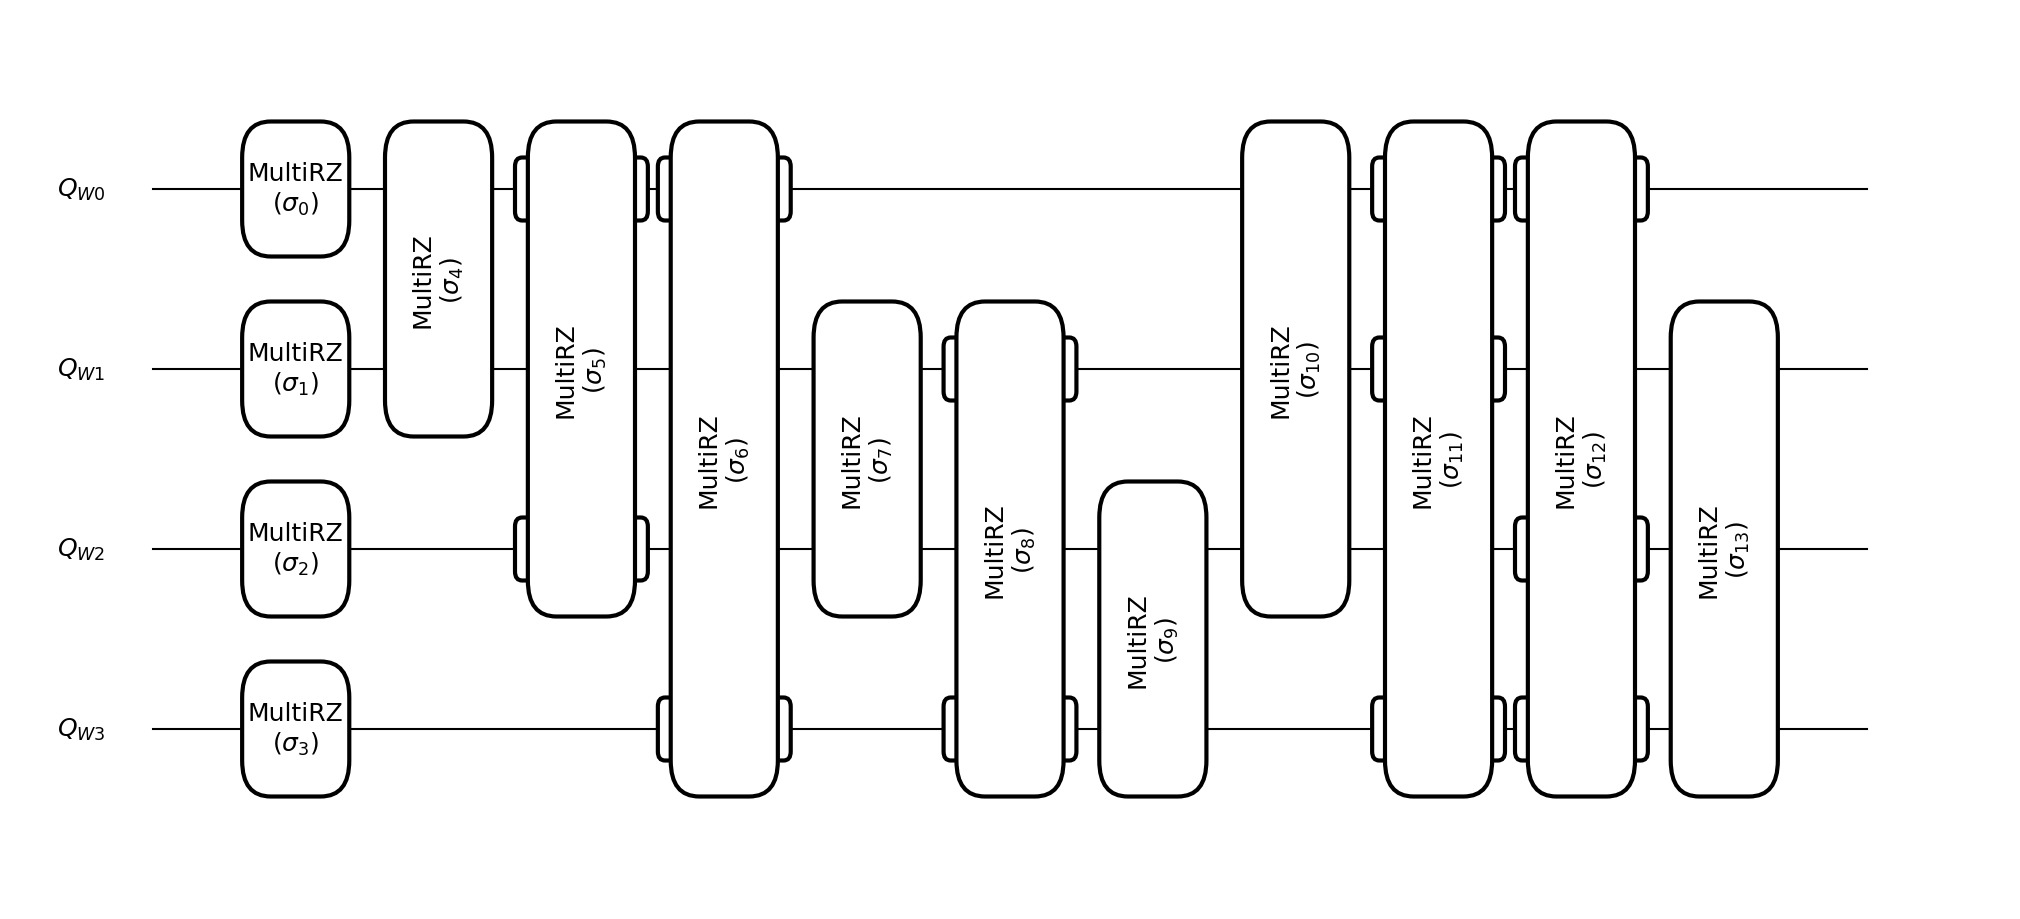

In [97]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import itertools

# --- CONFIGURATION ---
BITS_PER_TOKEN = 3
n_ancillas = 1
n_wires = BITS_PER_TOKEN + n_ancillas
H_LOCAL = 3 # Max interactions

wires_list = [f"$Q_{{W{i}}}$" for i in range(n_wires)]
dev = qml.device("default.qubit", wires=wires_list)

# --- HELPERS ---

def zstring_combos(wires):
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

# --- DRAWING FUNCTION ---

@qml.qnode(dev)
def draw_hamiltonian(gamma_vec):
    combos = zstring_combos(wires_list)
    gamma_subset = gamma_vec[:len(combos)]
    
    for gamma, combo in zip(gamma_subset, combos):
        qml.MultiRZ(gamma, wires=list(combo))
        

# --- DATA & PLOT ---

# Generate enough dummy labels
dummy_sigma = [f"$\\sigma_{{{i}}}$" for i in range(100)]

# Scale controls how spread out the gates are
fig, ax = qml.draw_mpl(draw_hamiltonian, scale=0.9, decimals=2)(dummy_sigma)

# Styling
fig.set_size_inches(20, 9)

# Apply font styling
for text in ax.texts:
    text.set_fontsize(18)
plt.tight_layout()
plt.show()